In [2]:
import pandas as pd
import pymongo
import sys 
sys.path.append("../") 
import src.support as sp 
import seaborn as sns

In [3]:
# Call the csv

df_cinema_award = pd.read_csv("../data/Cinema_Awards.csv", index_col=0)

In [4]:
# Conect with Mongo

client = pymongo.MongoClient()
client

MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True)

In [5]:
# Check our databases

client.list_database_names()

['Cinema_Awards_db', 'admin', 'alojamientos', 'config', 'local']

In [6]:
# Create a new database on Mongo DB

mydb = client["Cinema_Awards_db"]

In [7]:
# Create a brand new collectionion in our database

collection = mydb.details

In [8]:
# Insert data from our dataframe

collection.insert_many(df_cinema_award.to_dict("records"))

In [9]:
# Pass the query parameter without any specification, so it will return all the elements of the database

collection.find()

In [10]:
# Create a DataFrame from the extraction in Mongo

df_mongo = pd.DataFrame(collection.find())
df_mongo.head(2)

,_id,year_ceremony,category,name,film,oscar,golden_globe,sag,cca
0,63ce844b88334562ce59c23b,1990,Actor In A Leading Role,Kenneth Branagh,Henry V,Nominee,No,No,No
1,63ce844b88334562ce59c23c,1990,Actor In A Leading Role,Tom Cruise,Born On The Fourth Of July,Nominee,No,No,No


In [11]:
# Call the function create_year_range_df to filter my data frame between those 2 years

df_oscar_race = sp.create_year_range_df(1990, 2020, df_mongo)

In [12]:
# Create a new column indicating whether the nominee or winner won an Oscar

df_oscar_race['oscar_win'] = df_oscar_race.apply(lambda x: 1 if x['oscar'] == 'Winner' else 0, axis=1)
df_oscar_race['golden_globe_win'] = df_oscar_race.apply(lambda x: 1 if x['golden_globe'] == 'Winner' else 0, axis=1)
df_oscar_race['sag_win'] = df_oscar_race.apply(lambda x: 1 if x['sag'] == 'Winner' else 0, axis=1)
df_oscar_race['cca_win'] = df_oscar_race.apply(lambda x: 1 if x['cca'] == 'Winner' else 0, axis=1)

# Group the dataframe by actor/actress and film

grouped = df_oscar_race.groupby(["year_ceremony", "film"])

# Calculate the number of Oscar wins, nominations, and wins in the other awards

df_correlation1 = grouped.agg({'oscar_win': 'sum', 'golden_globe_win': 'count', 'sag_win': 'sum', 'cca_win': 'sum'}).reset_index()

C:\Users\juano\AppData\Local\Temp\ipykernel_9844\2245221602.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_oscar_race['oscar_win'] = df_oscar_race.apply(lambda x: 1 if x['oscar'] == 'Winner' else 0, axis=1)
C:\Users\juano\AppData\Local\Temp\ipykernel_9844\2245221602.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_oscar_race['golden_globe_win'] = df_oscar_race.apply(lambda x: 1 if x['golden_globe'] == 'Winner' else 0, axis=1)
C:\Users\juano\AppData\Local\Temp\ipykernel_9844\2245221602.py:5: Se

In [13]:
# Sort the values in descending order

df_corr = df_correlation1.sort_values(by='oscar_win', ascending=False)

In [14]:
# Drop the year for our heatmap

df_corr1 = df_corr.drop(['year_ceremony'], axis=1)

In [19]:
df_corr1

,film,oscar_win,golden_globe_win,sag_win,cca_win
91,The Silence Of The Lambs,10,18,0,0
950,The King'S Speech,8,28,2,0
163,Forrest Gump,8,28,2,0
640,Million Dollar Baby,8,22,4,0
466,A Beautiful Mind,8,22,2,0
...,...,...,...,...,...
506,Shrek,0,2,0,0
505,Sexy Beast,0,6,0,0
504,"Royal Tenenbaums, The",0,4,0,0
503,Road To Perdition,0,4,0,0


C:\Users\juano\AppData\Local\Temp\ipykernel_9844\3703217456.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df_corr1.corr()


<AxesSubplot: >

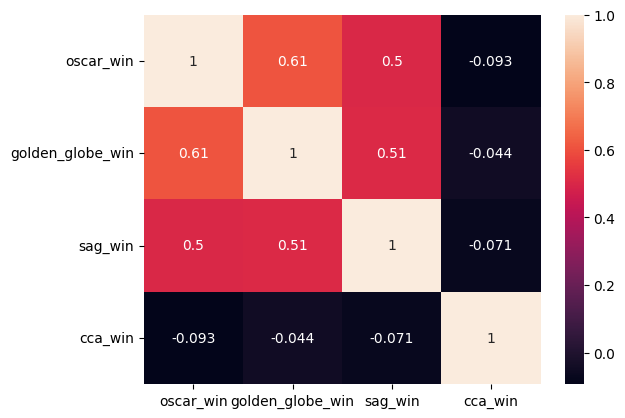

In [17]:
# Calculate the correlation between the number of wins in the other awards and the number of Oscar wins

corr = df_corr1.corr()

# Visualize the correlation matrix

sns.heatmap(corr, annot=True)